In [1]:

from logger import setup_logger
from model import BiSeNet

import torch

import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

In [2]:
def vis_parsing_maps(im, parsing_anno, stride, save_im=False, save_path='vis_results/parsing_map_on_im.jpg'):
    # Colors for all 20 parts
    part_colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0],
                   [255, 0, 85], [255, 0, 170],
                   [0, 255, 0], [85, 255, 0], [170, 255, 0],
                   [0, 255, 85], [0, 255, 170],
                   [0, 0, 255], [85, 0, 255], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = np.max(vis_parsing_anno)

    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    # print(vis_parsing_anno_color.shape, vis_im.shape)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.4, vis_parsing_anno_color, 0.6, 0)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] +'.png', vis_parsing_anno)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

    # return vis_im

In [ ]:
respth='./res/test_res'
dspth='/scratch/deepfake-captcha/real_frames/dome/'
cp='79999_iter.pth'

if not os.path.exists(respth):
    os.makedirs(respth)

n_classes = 19
net = BiSeNet(n_classes=n_classes)
net.cuda()
save_pth = osp.join('res/cp', cp)
net.load_state_dict(torch.load(save_pth))
net.eval()

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
i = 0
face_idx = [1, 2, 3, 4, 5, 10, 11, 12, 13]

with torch.no_grad():
    for image_path in os.listdir(dspth):
        img = Image.open(osp.join(dspth, image_path))
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        print(np.unique(parsing))
        i += 1
        if i > 1000:
            break
        for att in face_idx[1:]:
            parsing[parsing == att] = face_idx[0]
        vis_parsing_maps(image, parsing, stride=1, save_im=True, save_path=osp.join(respth, image_path))

[ 0  1  2  3  4 10 12 13 14 16 17]
[ 0  1  2  3  7 10 11 12 13 14 16 17]
[ 0  1  2  3 12 13 14 16 17]
[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 16 17]
[ 0  1  2  4  7  8 10 12 13 14 16 17]
[ 0  1  3  5  7  8 10 11 12 13 14 16 17]
[ 0  1  2  3  7 10 12 13 14 16 17]
[ 0  1  2  3  4  7  8 10 12 13 14 15 16 17]
[ 0  1  2  3  7  8 10 11 12 13 14 16 17]
[ 0  1  2  4  7  8 10 12 13 14 16 17]
[ 0  1  2  3  4  7 10 12 13 14 16 17]
[ 0  1  3  5  7  8 14 16 17 18]
[ 0  1  2  3  7  8 10 11 12 13 14 16 17]
[ 0  1  2  3  8 10 11 12 13 14 16 17]
[ 0  1  2  3  7  8 12 13 14 16 17]
[ 0  1  2  3  8 10 11 12 13 14 16 17]
[ 0  1  2  7 10 12 13 14 16 17]
[ 0  1  2  3  8 10 11 12 13 14 16 17]
[ 0  1  2  3  7 10 11 12 13 14 16 17]
[ 0  1  2  3  4  7  8 12 13 14 16 17]
[ 0  1  2  4  7 10 12 13 14 16 17]
[ 0  1  2  4  7  8 10 12 13 14 16 17]
[ 0  1  2  7 10 12 13 14 16 17 18]
[ 0  1  2  4  7 10 12 13 14 16 17]
[ 0  1  2  4 10 11 12 13 14 16 17]
[ 0  1  2  4  7  8 10 12 13 14 16 17]
[ 0  1  2  3  6 10 12 13 14

In [6]:
import os
import sys
sys.path.append('/home/govind/Workspace/fsgan')
weights_dir = '/home/govind/Workspace/fsgan/weights' #@param {type:"string"}

seg_model = os.path.join(weights_dir, 'v2/celeba_unet_256_1_2_segmentation_v2.pth')

from fsgan.utils.utils import set_device, load_model
S = load_model(seg_model, 'face segmentation', 'cuda')
dspth='/scratch/deepfake-captcha/real_frames/dome/'

=> Loading face segmentation model: "celeba_unet_256_1_2_segmentation_v2.pth"...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


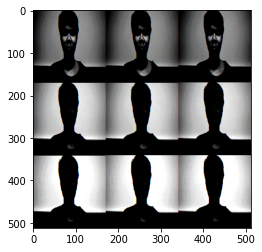

In [4]:
plt.imshow(img.cpu().detach().numpy()[0].reshape((512, 512, 3)))

In [85]:
np.unique(p2)

array([ 0,  1,  7,  8, 13, 14, 16, 17])

In [83]:
p2 = parsing.copy()

In [84]:
for att in face_idx[1:]:
    p2[p2 == att] = face_idx[0]

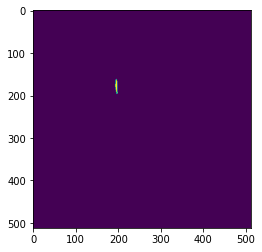

In [105]:
plt.imshow(p2 == 7)

In [26]:
parsing==1 & parsing==2

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [65]:
face[0]

'skin'

In [98]:
face_idx = [1, 2, 3, 4, 5, 9, 10, 11, 12]
parsed_face = (parsing == face_idx[0])
for att in face_idx[1:]:
    parsed_face = parsed_face | (parsing == att)

In [63]:
parsed_face.shape

AttributeError: 'bool' object has no attribute 'shape'

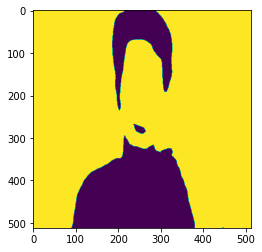

In [71]:
plt.imshow(parsed_face==1)

In [18]:
parsing.shape

(512, 512)

In [108]:
atts = ['skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear', 'r_ear', 'ear_r',
                'nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat']
print(np.array(atts)[[1, 2, 3, 4, 5,  10, 11, 12, 13]])

['l_brow' 'r_brow' 'l_eye' 'r_eye' 'eye_g' 'mouth' 'u_lip' 'l_lip' 'neck']


In [50]:
face = np.array(atts)[[0, 1, 2, 3, 4, 5, 9, 10, 11, 12]]

In [55]:
np.where(parsing in face)

<ipython-input-55-f0a9de9647c5>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  np.where(parsing in face)


(array([], dtype=int64),)